The following notebook develops a Zero-Inflated Poisson Regression model for the evaluation of object-oriented and CK metrics of various software releases to predict bug count and analyze the impact of coding practices on software quality.

In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

First, let's get the data and shuffle the observations.

In [14]:
# get data
metrics = pd.read_csv("dataset/cleaned_metrics.csv")

# shuffle observations
np.random.seed(3)
metrics = metrics.sample(frac=1, random_state=np.random.randint(0, 100))
metrics

,Unnamed: 0,numberOfBugsFoundUntil,numberOfNonTrivialBugsFoundUntil,numberOfMajorBugsFoundUntil,numberOfCriticalBugsFoundUntil,numberOfHighPriorityBugsFoundUntil,numberOfVersionsUntil,numberOfFixesUntil,numberOfRefactoringsUntil,numberOfAuthorsUntil,...,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,responseForAClass,weightedMethodsPerClass,bugs,nonTrivialBugs,majorBugs,criticalBugs,highPriorityBugs
1865,1865,19,19,0,0,0,37,8,0,11,...,0,2.0,12,55.0,22.0,3,0,0,0,0
2593,2593,1,1,0,0,0,1,0,0,1,...,0,0.0,1,8.0,3.0,0,0,0,0,0
3754,3754,1,0,0,0,0,1,0,0,1,...,0,0.0,2,10.0,3.0,0,0,0,0,0
2823,2823,3,1,0,0,0,4,1,0,1,...,0,0.0,3,42.0,9.0,2,1,0,0,0
4879,4880,12,12,1,0,2,63,3,1,8,...,0,0.0,20,133.0,70.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,2193,29,11,0,0,18,37,0,2,3,...,4,0.0,6,53.0,22.0,0,0,0,0,0
3473,3473,21,12,1,0,0,28,3,0,2,...,15,0.0,20,354.0,133.0,4,0,0,0,0
343,343,0,0,0,0,0,15,4,0,4,...,0,1.0,3,16.0,9.0,0,0,0,0,0
899,899,68,58,8,1,5,155,22,0,11,...,19,1.0,83,632.0,520.0,4,0,0,0,0


Next, we can extract y (bug count) and X (selected features) from the dataset.

In [15]:
# extract y
y = metrics['bugs'].reset_index(drop=True)
y

0       3
1       0
2       0
3       2
4       0
       ..
5365    0
5366    4
5367    0
5368    4
5369    0
Name: bugs, Length: 5370, dtype: int64

In [16]:
# extract X with selected features normalized
X = metrics[['numberOfBugsFoundUntil', 'CvsWEntropy', 'responseForAClass', 'numberOfLinesOfCode', 'depthOfInheritanceTree', 'fanOut']]
X = (X - X.mean(axis=0)) / X.std(axis=0)
X

,numberOfBugsFoundUntil,CvsWEntropy,responseForAClass,numberOfLinesOfCode,depthOfInheritanceTree,fanOut
1865,0.980300,0.994368,0.075199,-0.016872,0.037950,0.160615
2593,-0.432342,-0.325733,-0.390211,-0.324921,-0.708530,-0.648738
3754,-0.432342,-0.325733,-0.370406,-0.360970,-0.708530,-0.244062
2823,-0.275382,-0.325733,-0.053532,-0.138125,-0.708530,0.295507
4879,0.430939,0.257865,0.847581,0.337057,1.530909,0.700183
...,...,...,...,...,...,...
2193,1.765101,1.229056,0.055394,0.124044,-0.708530,-0.109170
3473,1.137260,-0.151594,3.035997,2.303329,-0.708530,3.937594
343,-0.510822,-0.311392,-0.310992,-0.288873,1.530909,-0.109170
899,4.825826,1.900001,5.788846,5.809847,-0.708530,5.691191


Now, we can develop the ZIP model. This model was developed using gradient ascent and a log-likelihood gain function. All equations and formulas are derived from [Sachin Date's description](https://timeseriesreasoning.com/contents/zero-inflated-poisson-regression-model/) of ZIP models.

In [17]:
# ZIP regression class
class ZIPRegression:
    def __init__(self, lr=1e-5, max_iter=2000, tol=1e-6):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.params = None
        self.logs = []

    # probability that y = 0
    def sigmoid(self, z):
        # sigmoid(z) = 1/(1 + exp(-z))
        return 1 / (1 + np.exp(-np.clip(z, -20, 20)))

    # calculate log likelihood (loss function)
    def log_likelihood(self, X, y, beta, gamma):

        # linear predictor for poisson mean
        eta = X @ beta

        # linear predictor for zero-inflation
        z = X @ gamma

        # expected poisson mean ()
        lambd = np.exp(np.clip(eta, -20, 20))
        phi = self.sigmoid(z)

        ll = 0
        for i in range(len(y)):
            # if y = 0, log-likelihood = log(ϕ + (1 - ϕ)exp(-λ))
            if y[i] == 0:
                p_zero = phi[i] + (1 - phi[i]) * np.exp(-lambd[i])
                ll += np.log(p_zero + 1e-10)
            # if y > 0, log-likelihood = log(1 - ϕ) + ylog(λ) - λ - log(y!)
            else:
                ll += np.log(1 - phi[i] + 1e-10)
                ll += y[i] * np.log(lambd[i] + 1e-10) - lambd[i] - self.log_factorial(y[i])
        return ll

    def log_factorial(self, n):
        return np.sum(np.log(np.arange(1, n + 1))) if n > 1 else 0.0

    # fit the midel using gradient ascent
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # initialize parameters to 0
        beta = np.zeros(n_features)
        gamma = np.zeros(n_features)

        # initialize last log likelihood to -inf
        last_ll = -np.inf

        # gradient ascent
        for it in range(self.max_iter):
            z = X @ gamma

            # lambda = exp(X*β)
            lambda_i = np.exp(np.clip(X @ beta, -20, 20))

            # phi = prob(y = 0)
            phi = self.sigmoid(z)

            # calculate gradients
            grad_beta = np.zeros_like(beta)
            grad_gamma = np.zeros_like(gamma)

            for i in range(n_samples):
                if y[i] == 0:
                    # P(y = 0) = ϕ + (1 - ϕ)exp(-λ)
                    p_zero = phi[i] + (1 - phi[i]) * np.exp(-lambda_i[i])
                    dL_dlambda = -(1 - phi[i]) * np.exp(-lambda_i[i]) / (p_zero + 1e-10)
                    dlambda_deta = lambda_i[i]
                    grad_beta += dL_dlambda * dlambda_deta * X[i]

                    dL_dphi = (1 - np.exp(-lambda_i[i])) / (p_zero + 1e-10)
                    dphi_dz = phi[i] * (1 - phi[i])
                    grad_gamma += dL_dphi * dphi_dz * X[i]

                else:
                    # P(y = k) = (1 - ϕ)((exp(-λ) * -λ^k) / k!)
                    grad_beta += (y[i] - lambda_i[i]) * X[i]
                    grad_gamma -= (phi[i] / (1 - phi[i] + 1e-10)) * phi[i] * (1 - phi[i]) * X[i]

            # update parameters
            beta += self.lr * grad_beta
            gamma += self.lr * grad_gamma

            # check convergence
            ll = self.log_likelihood(X, y, beta, gamma)
            if abs(ll - last_ll) < self.tol:
                break
            last_ll = ll
            self.logs.append(ll)

        self.params = np.concatenate([beta, gamma])

    # make predictiond for a dataset X
    def predict(self, X):
        n = X.shape[0]
        n_params = len(self.params) // 2
        beta = self.params[:n_params]
        gamma = self.params[n_params:]

        # set variables for simple calculations (X*β)
        eta = X @ beta
        z = X @ gamma

        # lambda = exp(X*β)
        lambd = np.exp(np.clip(eta, -20, 20))

        # phi = prob(y = 0)
        phi = self.sigmoid(z)

        # prediction loop
        predictions = np.zeros(n, dtype=int)
        for i in range(n):
            if np.random.rand() < phi[i]:
                predictions[i] = 0
            else:
                predictions[i] = np.random.poisson(lambd[i])
        return predictions



Fit and investigate the model.

In [18]:
# fit the model
zip = ZIPRegression()
zip.fit(X.values, y)

In [19]:
# take a look at the estimated coefficients
zip.params

array([ 0.08297027,  0.06091798,  0.02086071, -0.01073464, -0.11010223,
        0.00670685, -0.9356271 , -1.33647189, -0.99274793, -0.93128211,
       -0.04565677, -0.55557852])

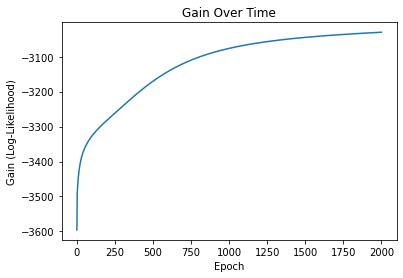

In [20]:
# look at convergence
loss = zip.logs
plt.plot(range(len(loss)), loss)
plt.xlabel('Epoch')
plt.ylabel('Gain (Log-Likelihood)')
plt.title('Gain Over Time')

plt.show()

In [21]:
# average ll per training sample
print("Average training error:", (loss[-1]/len(y)))

Average training error: -0.5642662314328862


Then, let's use sklearn library to perform K-Fold cross validation with K=5 to estimate the test error of the model.

In [22]:
# use sklearn library to perform k-fold cross validation
from sklearn.model_selection import KFold

# using 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=3)

X = X.to_numpy()
y = metrics['bugs'].values

log_likelihoods = []
zero_accuracies = []
count_accuracies = []
avg_count_differences = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = ZIPRegression()
    model.fit(X_train, y_train)
    
    beta_gamma = model.params
    beta = beta_gamma[:X.shape[1]]
    gamma = beta_gamma[X.shape[1]:]

    ll = model.log_likelihood(X_test, y_test, beta, gamma)

    # append average ll per sample
    log_likelihoods.append(ll / len(y_test))

    y_pred = model.predict(X_test)

    # zero accuracy: correctly predicted 0s where y_test == 0
    zero_mask = y_test == 0
    zero_correct = (y_pred[zero_mask] == 0).sum()
    zero_accuracy = zero_correct / zero_mask.sum() if zero_mask.sum() > 0 else np.nan
    zero_accuracies.append(zero_accuracy)

    # count accuracy: how often counts match where y > 0
    count_mask = y_test > 0
    count_correct = (y_pred[count_mask] == y_test[count_mask]).sum()
    count_accuracy = count_correct / count_mask.sum() if count_mask.sum() > 0 else np.nan
    count_accuracies.append(count_accuracy)

    # average prediction difference where y > 0
    if count_mask.sum() > 0:
        avg_count_diff = np.abs(y_pred[count_mask] - y_test[count_mask]).mean()
    else:
        avg_count_diff = np.nan
    avg_count_differences.append(avg_count_diff)


print(f"Average log-likelihood per sample: {np.mean(log_likelihoods):.4f}")
print(f"Average zero prediction accuracy: {np.nanmean(zero_accuracies):.4f}")
print(f"Average count prediction accuracy: {np.nanmean(count_accuracies):.4f}")
print(f"Average difference in predicted count where y > 0: {np.nanmean(avg_count_differences):.4f}")

Average log-likelihood per sample: -0.5696
Average zero prediction accuracy: 0.7842
Average count prediction accuracy: 0.1680
Average difference in predicted count where y > 0: 1.2450


Perform the same cross-validation on a baseline, simple poisson regression model to compare average log-likelihood.

In [23]:
# from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy.stats import poisson

kf = KFold(n_splits=5, shuffle=True, random_state=3)

log_likelihoods = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # add intercept to features
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # fit poisson regression
    poisson_model = sm.GLM(y_train, X_train_const, family=sm.families.Poisson())
    result = poisson_model.fit()

    # predict lambda for test set
    mu_test = result.predict(X_test_const)

    # compute log-likelihood on test set
    ll = np.sum(poisson.logpmf(y_test, mu=mu_test))
    log_likelihoods.append(ll / len(y_test)) 

print(f"Average log-likelihood per sample (Poisson regression): {np.mean(log_likelihoods):.4f}")


Average log-likelihood per sample (Poisson regression): -0.5941


Finally, we can look at the results. Let's look at the zero-inflation and count prediction coefficients by feature.

In [24]:
feature_names = ['numberOfBugsFoundUntil', 'CvsWEntropy', 'responseForAClass', 'numberOfLinesOfCode', 'depthOfInheritanceTree', 'fanOut']

# extract coefficients
n_features = X.shape[1]
beta = model.params[:n_features]
gamma = model.params[n_features:]

# create DataFrame for visualization
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Count_Coefficient (β)': beta,
    'Zero_Inflation_Coefficient (γ)': gamma
})

coeff_df

,Feature,Count_Coefficient (β),Zero_Inflation_Coefficient (γ)
0,numberOfBugsFoundUntil,0.071894,-0.876118
1,CvsWEntropy,0.069594,-1.202982
2,responseForAClass,0.001225,-0.921557
3,numberOfLinesOfCode,0.010580,-0.895570
4,depthOfInheritanceTree,-0.035721,0.088393
5,fanOut,0.010630,-0.568511
